# Project Overview

## Package Imports

In [1]:
# basic tools
import pandas as pd
import numpy as np
import time
from collections import Counter

# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split

# scoring and algorithm selection packages
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, HalvingGridSearchCV, learning_curve, StratifiedKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, f1_score

# resampling packages
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, NearMiss, RandomUnderSampler, OneSidedSelection, NeighbourhoodCleaningRule

# model packages
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier
import xgboost as xgb
from imblearn.ensemble import BalancedRandomForestClassifier

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import umap.plot
#import geopandas as gpd
#from shapely.geometry import Point,Polygon
#from descartes import PolygonPatch
#from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# ignore warnings (gets rid of Pandas copy warnings)
import warnings
warnings.filterwarnings('ignore')

## Notebook Functions

In [2]:
def pipeline_fit_preprocessor(x):
    
    ''' Takes in a dataframe and adds polynomial features and scaling
    arguments: dataframe
    returns: transformed dataframe and fit pipe object'''
    
    
    # Create a column transformer to add polynomial features to Segment Number
    print("Setting up transforms - Polynomials, StandardScaler")
    poly_transforms = ColumnTransformer(transformers=[
        ("polys", PolynomialFeatures(degree=3, include_bias=False), poly_features),
        ], remainder="passthrough") 
    
    

    print('Setting up processing pipeline')
    pipe = Pipeline([
                ('transforms1', poly_transforms),
                ('scl', StandardScaler()),
            ])
    
    print('Fitting pipeline on train data')
    transformed_data = pipe.fit_transform(x)
    
    # Re-apply labels
    category_labels = list(x.columns)
    category_labels.remove('SEGMENT_NUMBER')
    category_labels.remove('DEP_BLOCK_HIST')
    all_cols = ['SEGMENT_NUMBER', "DEP_BLOCK_HIST", "SEGMENT_POLY", "JUNK",  "DEP_BLOCK_HIST_POLY", "SEGMENT_POLY2", 
               "JUNK2", "JUNK3", "DEP_BLOCK_HIST_POLY2"]+list(category_labels)
    
    df= pd.DataFrame(transformed_data,  columns=all_cols, index=x.index)
    df.drop(['JUNK', 'JUNK2', 'JUNK3'], axis=1, inplace=True)
    
    return df, pipe

def pipeline_transform_preprocessor(x, pipe):
    
    ''' Takes in a dataframe and fit pipe object,
    and adds polynomial features and scaling
    arguments: dataframe, pipe object
    returns: transformed dataframe'''
    
    print('Transforming test data')
    transformed_data = pipe.transform(x)
    
    # Re-apply labels
    category_labels = list(x.columns)
    category_labels.remove('SEGMENT_NUMBER')
    category_labels.remove('DEP_BLOCK_HIST')
    all_cols = ['SEGMENT_NUMBER', "DEP_BLOCK_HIST", "SEGMENT_POLY", "JUNK",  "DEP_BLOCK_HIST_POLY", "SEGMENT_POLY2", 
               "JUNK2", "JUNK3", "DEP_BLOCK_HIST_POLY2"]+list(category_labels)
    
    df= pd.DataFrame(transformed_data,  columns=all_cols, index=x.index)
    df.drop(['JUNK', 'JUNK2', 'JUNK3'], axis=1, inplace=True)
    
    return df


In [61]:
def spot_check_classifier(model, train, y_train, title, test, y_test):
    
    '''Takes in a model as well as train and test sets. Runs model using cv 3 and appends model scores to the list
    Arguments:
    model pre-defined with hyperparameters
    train and test x and y
    title string to define the model on the scores list'''
    
    # log start time of model run
    start=time.time()
    
    # Identify model being run
    print("\n\nRunning", title, "Classification")
    
    # fit model to train data
    model.fit(train, y_train)
    
    # get accuracy cross val score for cv 3
    scores = cross_validate(model, train, y_train, cv=3,
        scoring=('f1_macro', 'balanced_accuracy', 'roc_auc_ovr'),
        return_train_score=True)
    f1 = round(scores['test_f1_macro'].mean()*100,2)
    accs = round(scores['test_balanced_accuracy'].mean()*100, 2)
    auc = round(scores['test_roc_auc_ovr'].mean()*100, 2)
    
    print("CV 3 Accuracy Train Score: {}".format(accs))
    print("CV 3 F1 Train Score: {}".format(f1))
    print("CV 3 Auc Train Score: {}".format(auc))
    
    # make predictions on test data
    preds = model.predict(test)
    probs = model.predict_proba(test)
    
    # Print Testing accuracy
    accs = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    auc = roc_auc_score(y_test, probs, average='macro', multi_class='ovr')
    print('\nTesting Accuracy: ', accs)
    print('Testing f1 Score: ', f1)
    print('Testing AUC Score: ', auc, '\n')
    
    # print classification report
    print(classification_report(y_test, preds))
    
    # append our results to our lists
    spot_check['Model'].append(title)
    spot_check['f1'].append(f1)
    spot_check['accuracy'].append(accs)
    spot_check['auc'].append(auc)
    spot_check['time'].append(time.time() - start)
    
    print(f'Elapsed Time: {time.time() - start}') 

In [62]:
def make_classifier(model, train, test, y_train, y_test, title):
    
    '''Takes in a model as well as train and test sets. Runs model using cv 5 and appends model scores to the list.
    This model prints a confusion matrix and visual ROCUC. 
    Arguments:
    model pre-defined with hyperparameters
    train and test x and y
    title string to define the model on the scores list'''
    
    # log start time of model run
    start=time.time()
    
    # Identify model being run
    print("\n\nRunning", title, "Classification")
    
    # fit model to train data
    model.fit(train, y_train)
    
    # get accuracy cross val score for cv 10
    scores = cross_validate(model, train, y_train, cv=10,
        scoring=('f1_macro', 'balanced_accuracy', 'roc_auc_ovr'),
        return_train_score=True)
    f1 = round(scores['test_f1_macro'].mean()*100,2)
    accs = round(scores['test_balanced_accuracy'].mean()*100, 2)
    auc = round(scores['test_roc_auc_ovr'].mean()*100, 2)
    
    print("CV 10 Accuracy Train Score: {}".format(accs))
    print("CV 10 F1 Train Score: {}".format(f1))
    print("CV 10 Auc Train Score: {}".format(auc))
    
    # make predictions on test data
    preds = model.predict(test)
    
    # Print Testing accuracy
    accuracy = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    auc = roc_auc_score(y_test, probs, average='macro', multi_class='ovr')
    print('\nTesting Accuracy: ', accuracy)
    print('Testing f1 Score: ', f1)
    print('Testing AUC Score: ', auc, '\n')
    
    # print classification report
    print(classification_report(y_test, preds))
    
    # Visualize Confusion Matrix
    print("\nConfusion Matrix for Test Set")
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_title('Confusion Matrx')
    plot_confusion_matrix(model, test, y_test, cmap=plt.cm.Blues, ax=ax)
    plt.show()
    
    # Get false positive, true positive, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, preds)

    # Visualize AUC
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    plt.figure(figsize=(15,10))
    plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # append our scores to our lists
    models['Model'].append(title)
    models['f1'].append(f1)
    models['accuracy'].append(accuracy)
    models['auc'].append(auc)
    models['time'].append(time.time() - start)
    
    print(f'Elapsed Time: {time.time() - start}')

In [5]:
def grid_optimizer(model, grid, x, y):
    
    '''Takes in a model and a grid of hyperparameters, and runs a HalvingGridSearch
    arguments: model, parameter grid, x and y to check parameter grid
    returns: best parameters'''
    
    start=time.time()
    
    print("Making Search")
    grid_search = HalvingGridSearchCV(model, grid, verbose=10, scoring='roc_auc', cv=3, n_jobs=-1, min_resources='exhaust')

    print("Running Grid")
    grid_search.fit(x, y)

    grid_search.best_estimator_
    
    # Best f1
    print('Best roc_auc: %.3f' % grid_search.best_score_)

    print("Best parameters set found on train set: \n")
    print(grid_search.best_params_)
    print("\nGrid scores on train set:\n")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    print(f'Elapsed Time: {time.time() - start}')
    
    return grid_search.best_params_

# Explore/Visualize Data

In [6]:
# Load ALL Data
final = pd.read_pickle("data/pkl/train_delays.pkl")
final

,MONTH,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,...,PRCP,SNOW,SNWD,TMAX,AWND,DELAY_REASON,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
0,4,7,2100-2159,3,1,33,50,American Eagle Airlines Inc.,7011,25138,...,0.00,0.0,0.0,86.0,7.16,CARRIER,0.146509,0.204697,0.203729,0.264607
1,3,4,2200-2259,1,5,11,100,JetBlue Airways,11110,25502,...,0.00,0.0,0.0,57.0,11.18,MIXED,0.249290,0.165380,0.179152,0.194965
2,5,4,1800-1859,2,5,15,143,Southwest Airlines Co.,5562,113709,...,0.00,0.0,0.0,84.0,8.05,LATE_AIRCRAFT,0.248016,0.239330,0.250504,0.309200
3,3,1,1700-1759,3,5,28,142,United Air Lines Inc.,11006,53007,...,0.16,0.0,0.0,60.0,9.17,NAS,0.184016,0.180546,0.161062,0.224798
4,8,1,1800-1859,6,8,10,143,Southwest Airlines Co.,4742,114987,...,1.40,0.0,0.0,78.0,6.04,LATE_AIRCRAFT,0.192933,0.242930,0.181530,0.309009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710859,4,1,2000-2059,1,8,23,100,JetBlue Airways,12669,24966,...,0.31,0.0,0.0,54.0,11.63,LATE_AIRCRAFT,0.266494,0.149187,0.238144,0.247386
710860,5,6,1100-1159,5,3,20,181,American Airlines Inc.,8145,78894,...,0.04,0.0,0.0,88.0,10.96,LATE_AIRCRAFT,0.256803,0.286236,0.179506,0.163243
710861,2,4,1200-1259,6,2,50,76,Mesa Airlines Inc.,13272,15953,...,0.02,0.0,0.0,84.0,7.16,CARRIER,0.208413,0.145307,0.244909,0.228026
710862,8,4,1800-1859,1,7,3,50,Comair Inc.,1181,24496,...,0.00,0.0,0.0,89.0,4.92,LATE_AIRCRAFT,0.232407,0.209670,0.241347,0.309009


In [7]:
y = final['DELAY_REASON'].value_counts()
y

LATE_AIRCRAFT    298668
CARRIER          205794
MIXED            101703
NAS               79854
WEATHER           23541
SECURITY           1304
Name: DELAY_REASON, dtype: int64

''

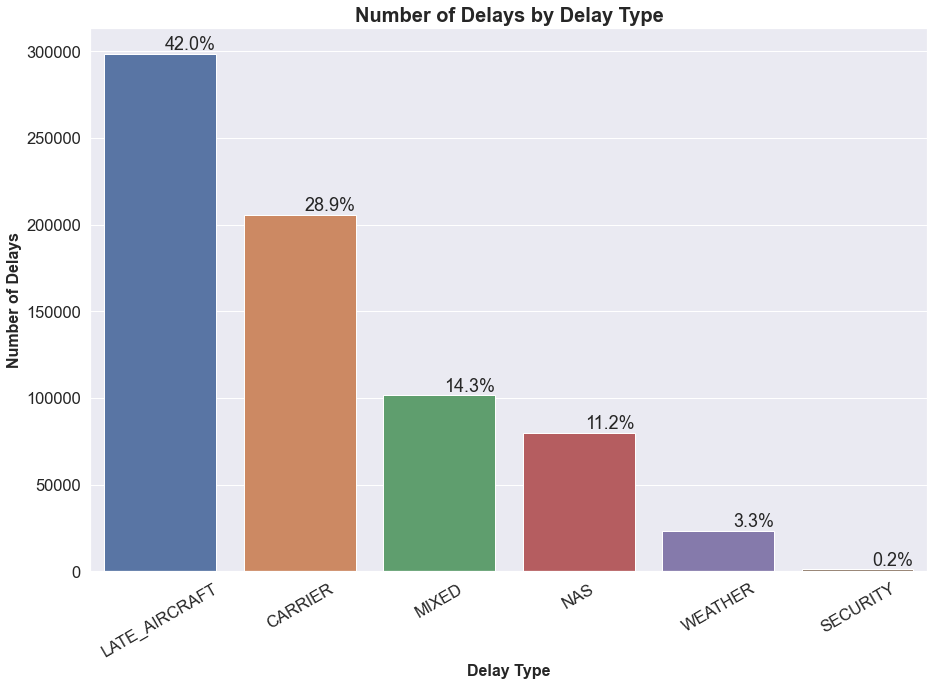

In [8]:
sns.set(font_scale = 1.5) # reset our scale

# create our figure
fig, ax=plt.subplots(figsize=(15,10))


# set up our barplot
bar4 = sns.barplot(x=y.index, y=y, data=final)


total = float(sum(y))

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha="right",va="bottom")


# label our visualization

bar4.set_xticklabels(bar4.get_xticklabels(),rotation=30)
bar4.set_ylabel('Number of Delays',weight='bold',fontsize=16)
bar4.set_xlabel('Delay Type', weight='bold',fontsize=16)
bar4.set_title('Number of Delays by Delay Type',weight='bold',fontsize=20)

# save figure to png
#plt.savefig('images/delay_type.png')
;


In [9]:
# Drop categoricals that we were using for our visualizations 

final.drop(columns=['CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'MONTH'], axis=1, inplace=True)

## Correlations

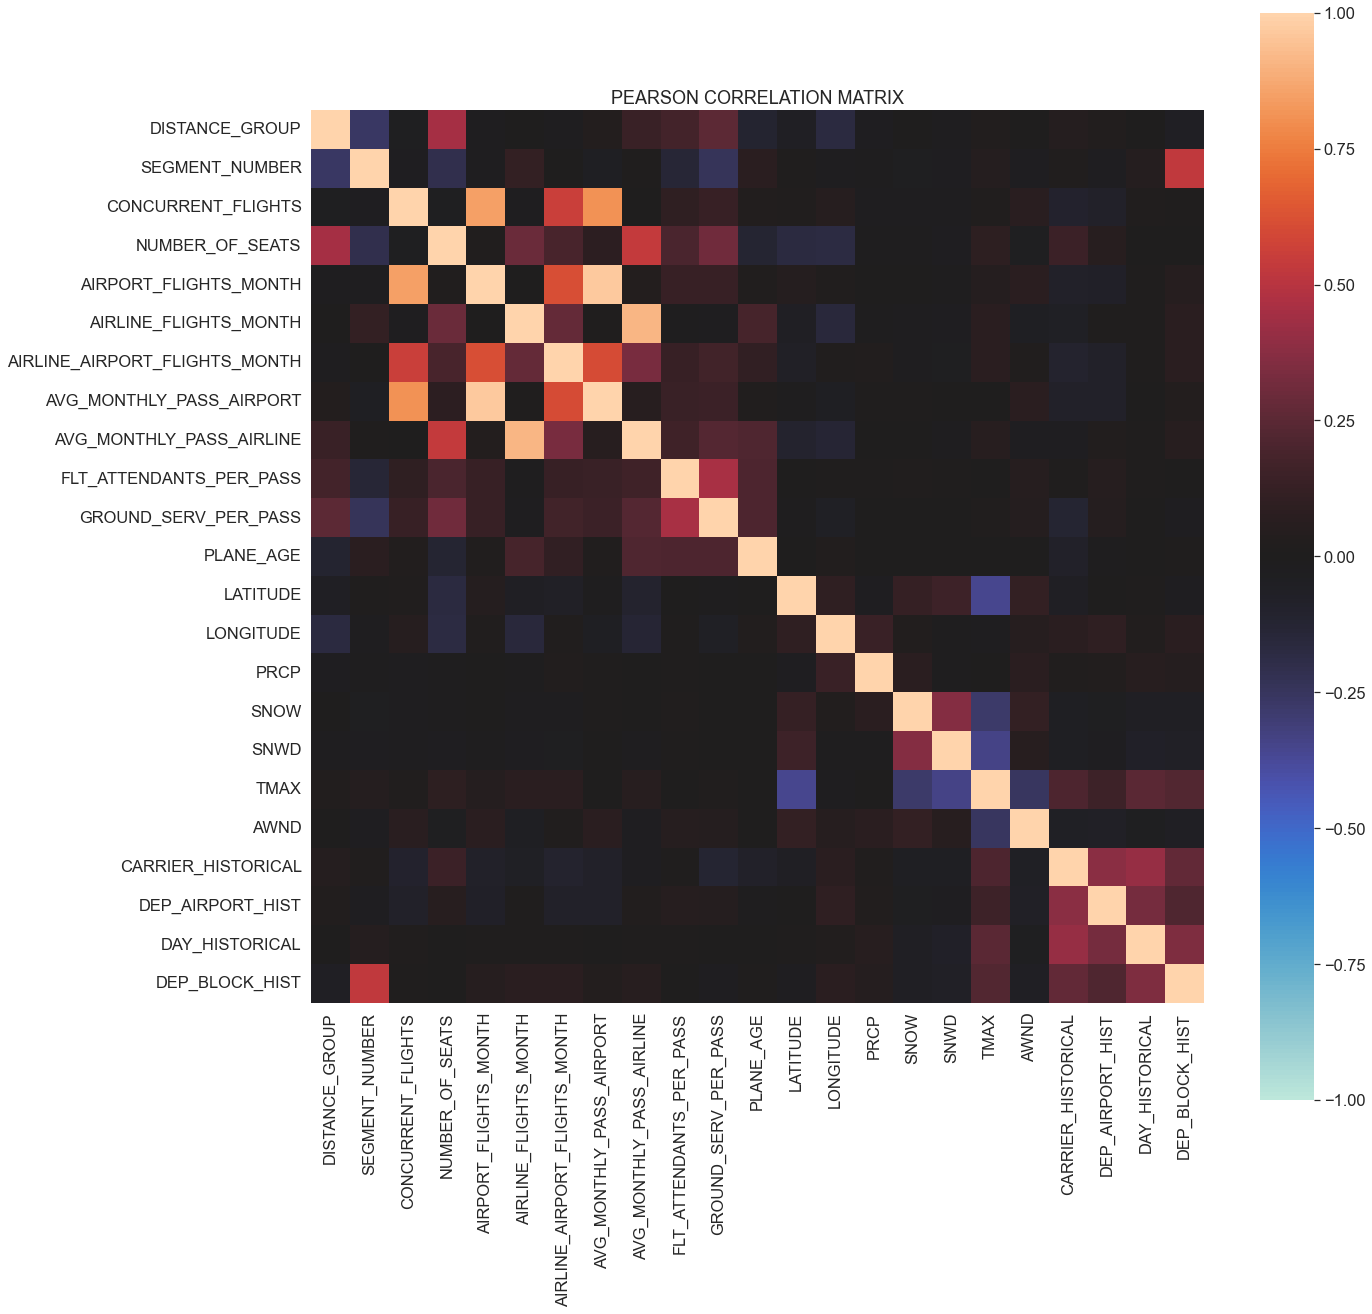

In [10]:
# look for multicollinearity of features
fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(final.corr(), center=0,  
           vmin=-1, vmax=1,  square=True)

# title
plt.title('PEARSON CORRELATION MATRIX', fontsize=18)

plt.show()

In [11]:
final.corr()

,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,...,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
DISTANCE_GROUP,1.000000,-0.265207,-0.035722,0.448084,-0.016900,0.003242,-0.018316,0.035589,0.134178,0.178586,...,-0.168641,-0.025409,0.000516,-0.015714,0.029035,0.006552,0.045062,0.030632,0.000447,-0.050338
SEGMENT_NUMBER,-0.265207,1.000000,-0.030765,-0.208664,-0.018262,0.116145,0.004303,-0.042856,0.012444,-0.133721,...,-0.018149,-0.011655,-0.033753,-0.029015,0.042444,-0.028521,0.017692,-0.026022,0.040640,0.526774
CONCURRENT_FLIGHTS,-0.035722,-0.030765,1.000000,-0.032717,0.844344,-0.019355,0.555035,0.804869,0.004454,0.098527,...,0.049739,-0.020823,-0.021986,-0.015640,0.023344,0.062855,-0.097399,-0.078336,0.018665,0.012188
NUMBER_OF_SEATS,0.448084,-0.208664,-0.032717,1.000000,0.021475,0.290308,0.187699,0.083618,0.537078,0.196636,...,-0.173241,-0.009359,-0.010912,-0.029944,0.090388,-0.032187,0.144203,0.055346,0.000766,0.005910
AIRPORT_FLIGHTS_MONTH,-0.016900,-0.018262,0.844344,0.021475,1.000000,0.003633,0.616948,0.964361,0.031310,0.129597,...,0.019005,0.006752,0.001151,-0.011685,0.039455,0.077503,-0.080065,-0.077484,0.011509,0.049750
AIRLINE_FLIGHTS_MONTH,0.003242,0.116145,-0.019355,0.290308,0.003633,1.000000,0.277007,0.014477,0.907111,-0.011361,...,-0.153622,-0.008449,-0.016488,-0.025145,0.075416,-0.044375,-0.061076,0.010628,0.013772,0.070491
AIRLINE_AIRPORT_FLIGHTS_MONTH,-0.018316,0.004303,0.555035,0.187699,0.616948,0.277007,1.000000,0.606116,0.334508,0.130500,...,0.018897,0.030408,-0.020031,-0.031318,0.075146,0.016489,-0.108661,-0.079436,0.009557,0.074448
AVG_MONTHLY_PASS_AIRPORT,0.035589,-0.042856,0.804869,0.083618,0.964361,0.014477,0.606116,1.000000,0.060685,0.139560,...,-0.042862,0.008645,0.011350,0.003086,0.002432,0.076036,-0.078813,-0.079995,0.004938,0.038835
AVG_MONTHLY_PASS_AIRLINE,0.134178,0.012444,0.004454,0.537078,0.031310,0.907111,0.334508,0.060685,1.000000,0.158982,...,-0.131433,0.001303,-0.007309,-0.023066,0.059459,-0.031187,-0.026273,0.027073,0.012899,0.056634
FLT_ATTENDANTS_PER_PASS,0.178586,-0.133721,0.098527,0.196636,0.129597,-0.011361,0.130500,0.139560,0.158982,1.000000,...,0.012623,0.009794,0.021470,0.009820,-0.002912,0.052598,0.013737,0.053113,0.008113,-0.007724


In [12]:
#Get our list of highly correlated feature pairs:

# save correlation matrix as a new data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df_correlations = final.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_correlations['pairs'] = list(zip(df_correlations.level_0, df_correlations.level_1))

# set index to pairs
df_correlations.set_index(['pairs'], inplace = True)

# rename our results column to correlation
df_correlations.rename(columns={0: "correlation"}, inplace=True)

# Drop 1:1 correlations to get rid of self pairs
df_correlations.drop(df_correlations[df_correlations['correlation'] == 1.000000].index, inplace=True)

# view pairs above 75% correlation and below 95% correlation (engineered features will correlate with each other above 95%)
df_correlations[(df_correlations.correlation>.75) & (df_correlations.correlation<.95)]


,level_0,level_1,correlation
pairs,,,
"(AIRLINE_FLIGHTS_MONTH, AVG_MONTHLY_PASS_AIRLINE)",AIRLINE_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRLINE,0.907111
"(AVG_MONTHLY_PASS_AIRLINE, AIRLINE_FLIGHTS_MONTH)",AVG_MONTHLY_PASS_AIRLINE,AIRLINE_FLIGHTS_MONTH,0.907111
"(AIRPORT_FLIGHTS_MONTH, CONCURRENT_FLIGHTS)",AIRPORT_FLIGHTS_MONTH,CONCURRENT_FLIGHTS,0.844344
"(CONCURRENT_FLIGHTS, AIRPORT_FLIGHTS_MONTH)",CONCURRENT_FLIGHTS,AIRPORT_FLIGHTS_MONTH,0.844344
"(AVG_MONTHLY_PASS_AIRPORT, CONCURRENT_FLIGHTS)",AVG_MONTHLY_PASS_AIRPORT,CONCURRENT_FLIGHTS,0.804869
"(CONCURRENT_FLIGHTS, AVG_MONTHLY_PASS_AIRPORT)",CONCURRENT_FLIGHTS,AVG_MONTHLY_PASS_AIRPORT,0.804869


In [13]:
# drop highly correlated features
final.drop(columns=['AVG_MONTHLY_PASS_AIRLINE', 'AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT'], axis=1, inplace=True)

In [15]:
final

,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,LATITUDE,...,PRCP,SNOW,SNWD,TMAX,AWND,DELAY_REASON,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
0,3,1,33,50,25138,798,0.000348,0.000107,15,25.792,...,0.00,0.0,0.0,86.0,7.16,CARRIER,0.146509,0.204697,0.203729,0.264607
1,1,5,11,100,25502,3462,0.000160,0.000127,14,40.639,...,0.00,0.0,0.0,57.0,11.18,MIXED,0.249290,0.165380,0.179152,0.194965
2,2,5,15,143,113709,930,0.000062,0.000099,14,35.875,...,0.00,0.0,0.0,84.0,8.05,LATE_AIRCRAFT,0.248016,0.239330,0.250504,0.309200
3,3,5,28,142,53007,694,0.000254,0.000229,24,47.447,...,0.16,0.0,0.0,60.0,9.17,NAS,0.184016,0.180546,0.161062,0.224798
4,6,8,10,143,114987,2090,0.000062,0.000099,13,39.298,...,1.40,0.0,0.0,78.0,6.04,LATE_AIRCRAFT,0.192933,0.242930,0.181530,0.309009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710859,1,8,23,100,24966,4532,0.000160,0.000127,12,42.364,...,0.31,0.0,0.0,54.0,11.63,LATE_AIRCRAFT,0.266494,0.149187,0.238144,0.247386
710860,5,3,20,181,78894,498,0.000098,0.000177,2,26.074,...,0.04,0.0,0.0,88.0,10.96,LATE_AIRCRAFT,0.256803,0.286236,0.179506,0.163243
710861,6,2,50,76,15953,2435,0.000000,0.000091,2,29.983,...,0.02,0.0,0.0,84.0,7.16,CARRIER,0.208413,0.145307,0.244909,0.228026
710862,1,7,3,50,24496,251,0.000000,0.000090,15,36.092,...,0.00,0.0,0.0,89.0,4.92,LATE_AIRCRAFT,0.232407,0.209670,0.241347,0.309009


## UMAP

In [16]:
# fit umap to data

umap_set = final.drop('DELAY_REASON', axis=1)
mapper = umap.UMAP().fit(umap_set)

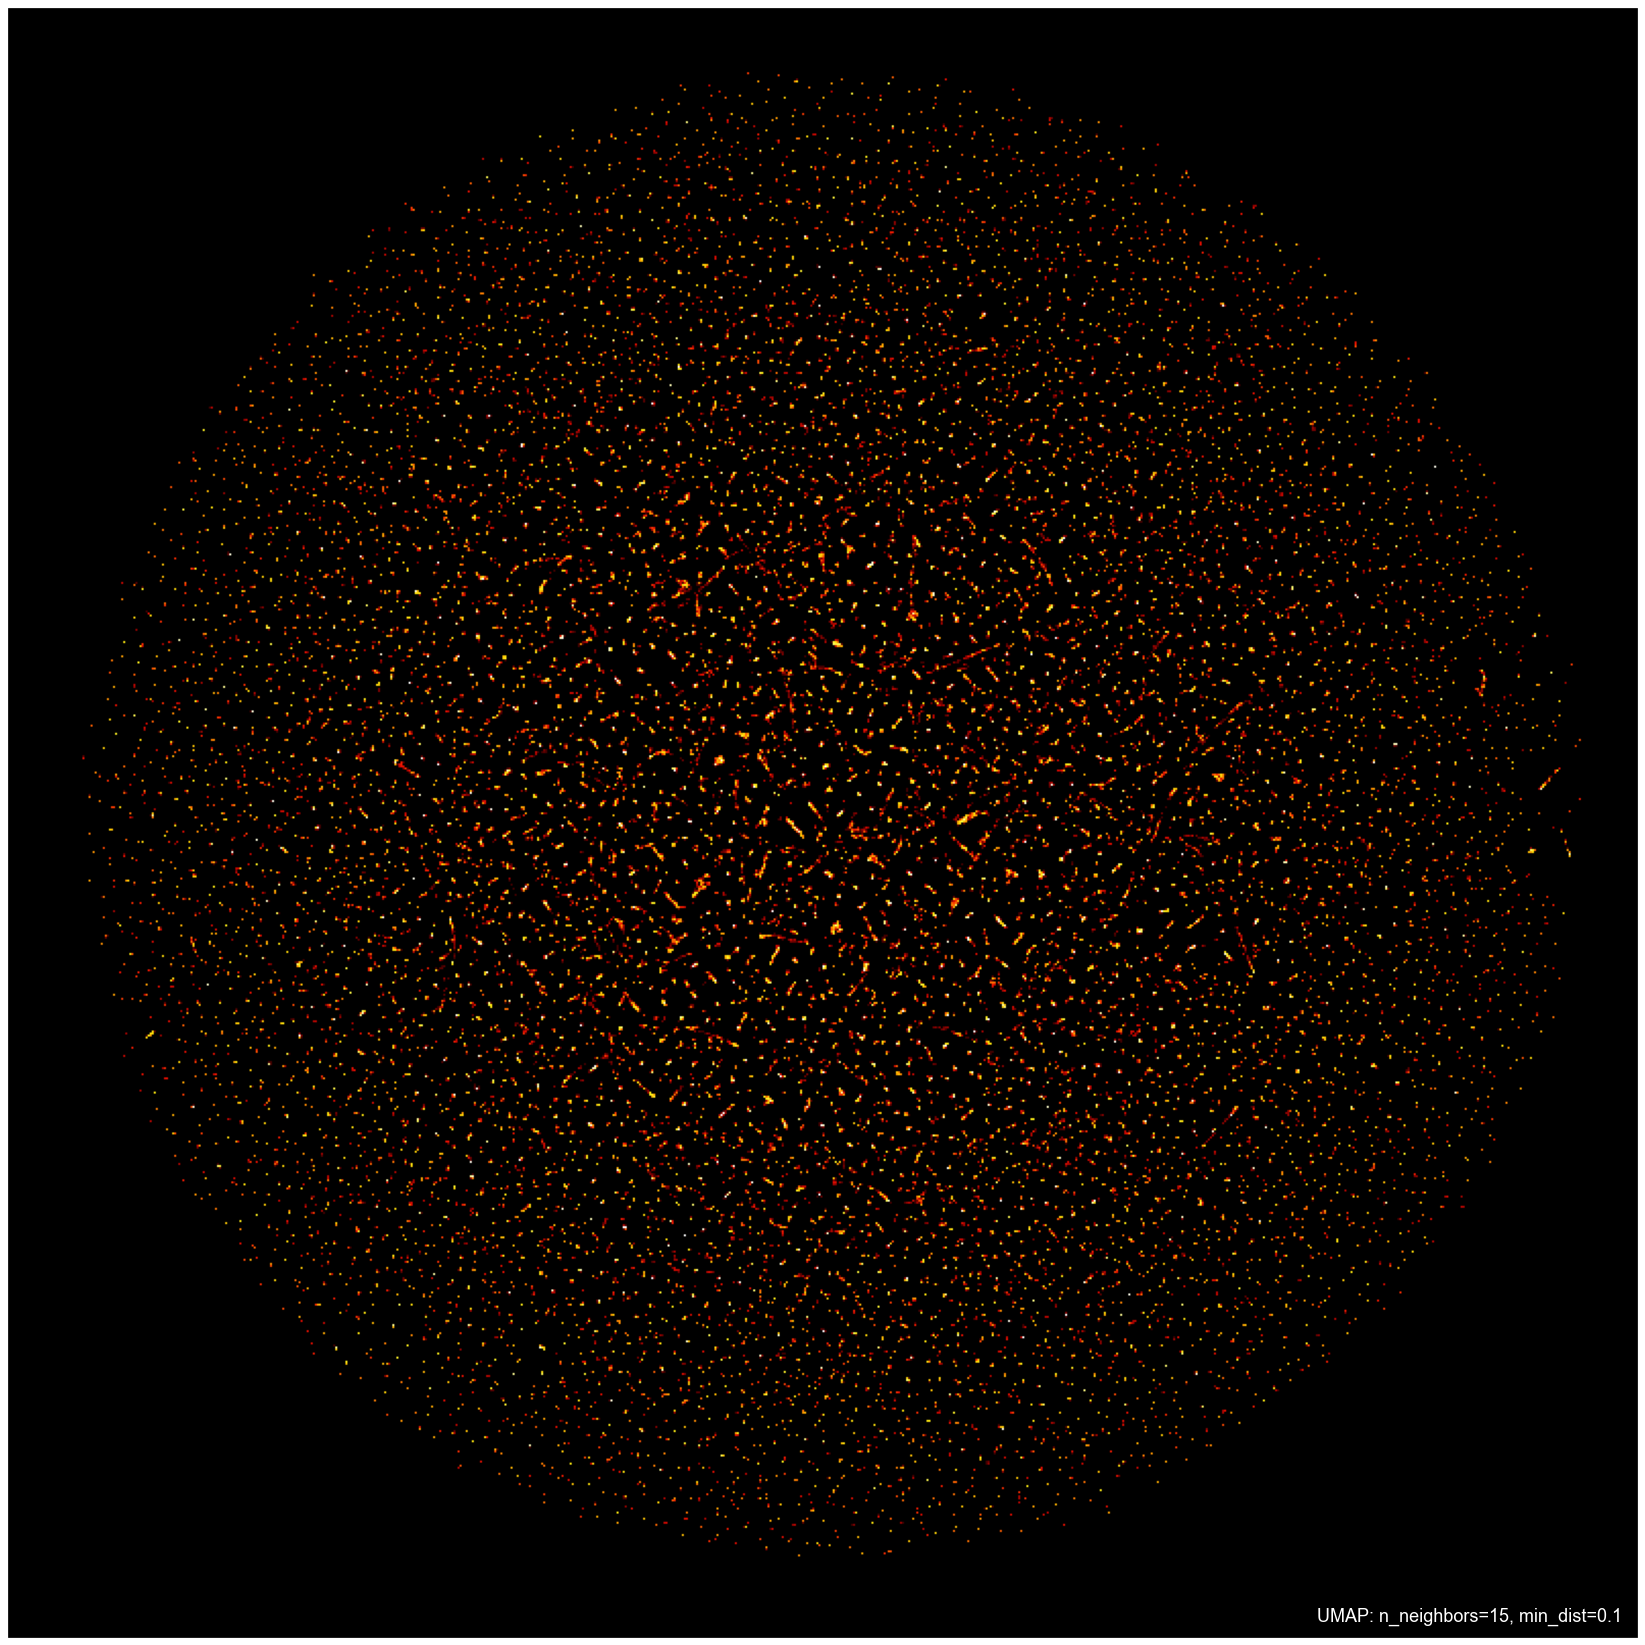

In [31]:
# plot umap

fig, ax = plt.subplots(figsize=(30,30))
umap.plot.points(mapper, theme='fire', ax=ax)

# save figure
plt.savefig('images/umap_delays.png');

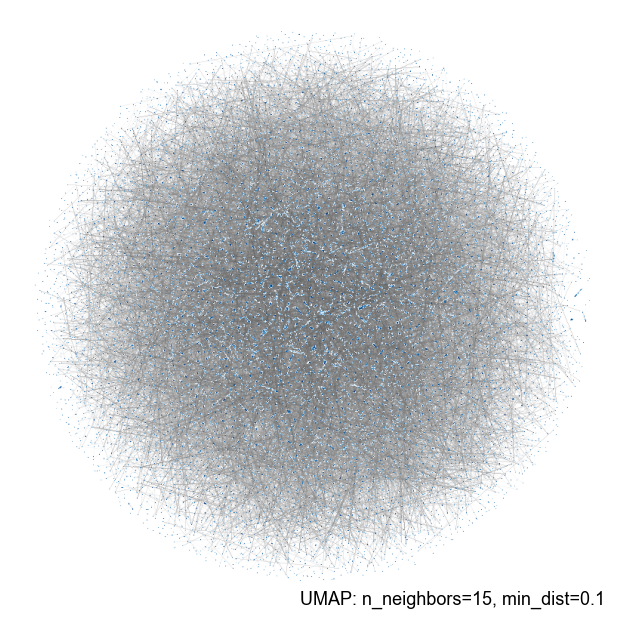

In [18]:
# show umap connectivity

umap.plot.connectivity(mapper, show_points=True)

# save figure
plt.savefig('images/umap_connect_delays.png')

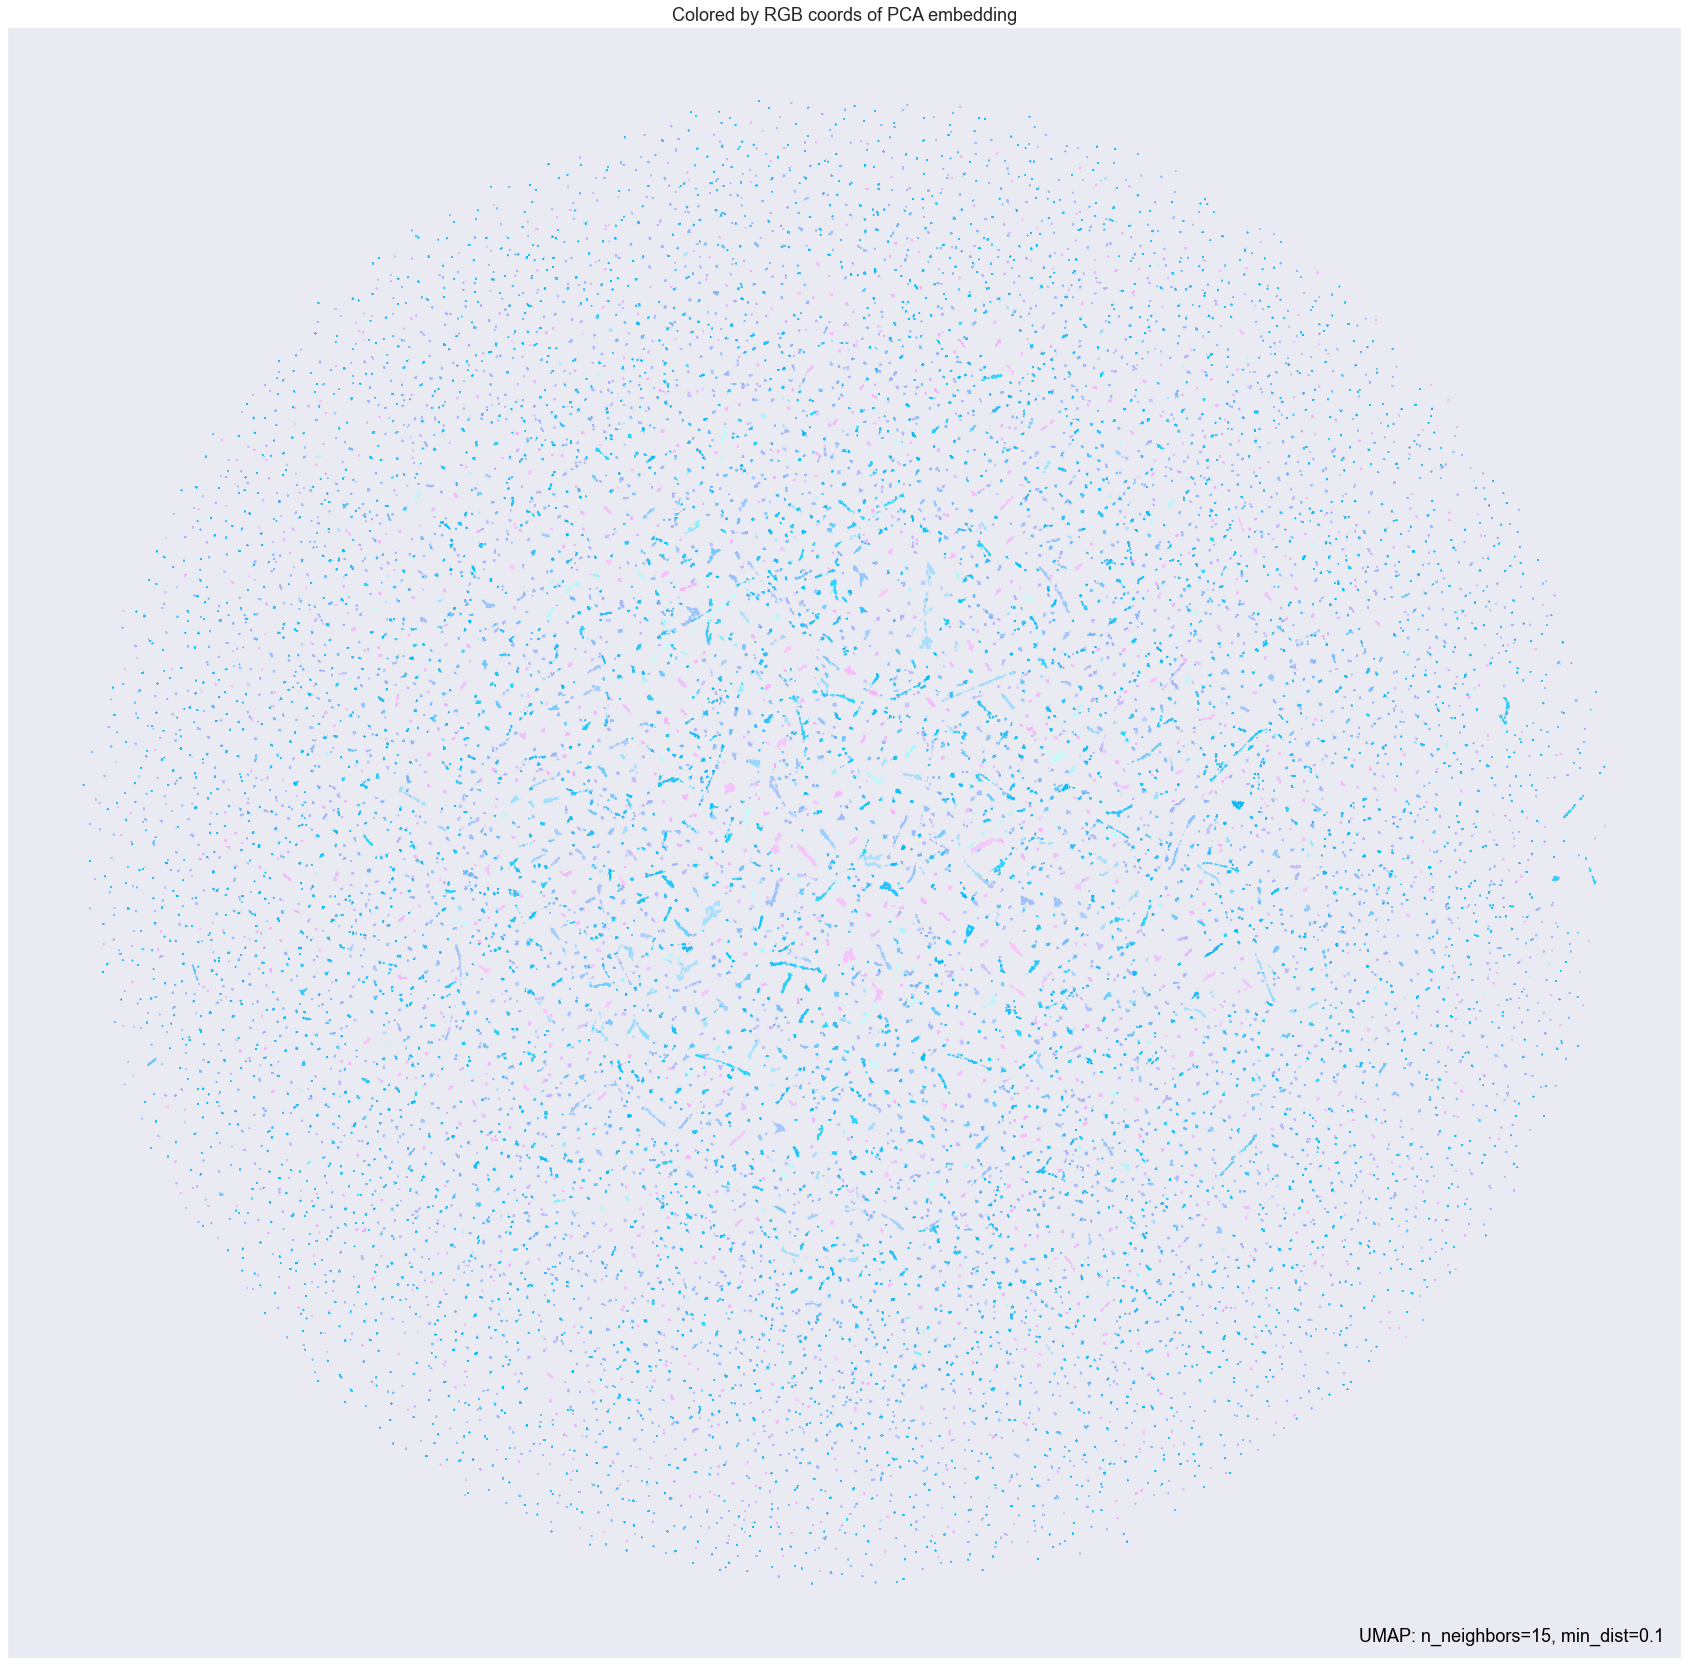

In [19]:
# 

fig, ax = plt.subplots(figsize=(30,30))
umap.plot.diagnostic(mapper, diagnostic_type='pca', ax=ax)

# save figure
plt.savefig('images/umap_diagnostic_pca_delays.png')

# Modeling

In [63]:
# prepare dictionary to store testing results

randomstate=42

spot_check = {}
spot_check['Model'] = []
spot_check['f1'] = []
spot_check['accuracy'] = []
spot_check['auc'] = []
spot_check['time'] = []

models = {}
models['Model'] = []
models['f1'] = []
models['accuracy'] = []
models['auc'] = []
models['time'] = []

In [64]:
print('Raw counts: \n')
print(final['DELAY_REASON'].value_counts())
print('-----------------------------------')
print('Normalized counts: \n')
print(final['DELAY_REASON'].value_counts(normalize=True))

Raw counts: 

LATE_AIRCRAFT    298668
CARRIER          205794
MIXED            101703
NAS               79854
WEATHER           23541
SECURITY           1304
Name: DELAY_REASON, dtype: int64
-----------------------------------
Normalized counts: 

LATE_AIRCRAFT    0.420148
CARRIER          0.289498
MIXED            0.143070
NAS              0.112334
WEATHER          0.033116
SECURITY         0.001834
Name: DELAY_REASON, dtype: float64


In [65]:
# Make x-train and y-train
x_train = final.drop('DELAY_REASON', axis=1)
y_train = final['DELAY_REASON']

In [66]:
# load in validation data (from OS_dataset_cleanup)
val = pd.read_pickle('data/pkl/test_delays.pkl')

x_val = val.drop('DELAY_REASON', axis=1)
y_val = val['DELAY_REASON']

x_val.drop(columns=['AVG_MONTHLY_PASS_AIRLINE', 'AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT', 'CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'MONTH'], axis=1, inplace=True)


## Processing Pipelines

In [67]:
# set up processing categories

features_cat = [col for col in x_train.columns if x_train[col].dtype in [object]]

cont_features = [col for col in x_train.columns if x_train[col].dtype in [np.float64, np.int64, np.int32, np.int16, np.int8]]

poly_features = ['SEGMENT_NUMBER', 'DEP_BLOCK_HIST']

features_cat, cont_features, poly_features

([],
 ['DISTANCE_GROUP',
  'SEGMENT_NUMBER',
  'CONCURRENT_FLIGHTS',
  'NUMBER_OF_SEATS',
  'AIRLINE_FLIGHTS_MONTH',
  'AIRLINE_AIRPORT_FLIGHTS_MONTH',
  'FLT_ATTENDANTS_PER_PASS',
  'GROUND_SERV_PER_PASS',
  'PLANE_AGE',
  'LATITUDE',
  'LONGITUDE',
  'PRCP',
  'SNOW',
  'SNWD',
  'TMAX',
  'AWND',
  'CARRIER_HISTORICAL',
  'DEP_AIRPORT_HIST',
  'DAY_HISTORICAL',
  'DEP_BLOCK_HIST'],
 ['SEGMENT_NUMBER', 'DEP_BLOCK_HIST'])

In [68]:
processed_train, pipe = pipeline_fit_preprocessor(x_train)
processed_val = pipeline_transform_preprocessor(x_val, pipe)

Setting up transforms - Polynomials, StandardScaler
Setting up processing pipeline
Fitting pipeline on train data
Transforming test data


In [69]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)


## Spot Check Models

In [70]:
weighted_models = {
    "Logistic Regression_Weighted": LogisticRegression(class_weight='balanced', solver='saga',
                                multi_class= 'multinomial',
                                penalty='l1',
                                max_iter=7,
                                random_state=randomstate,
                               C=1e12,
                               fit_intercept=False,),
    "Decision Tree Classifier_Weighted": DecisionTreeClassifier(class_weight='balanced', random_state=randomstate),
    "Extra Trees_Weighted" : ExtraTreesClassifier(class_weight='balanced', random_state=randomstate, n_jobs=-1),
    "Random Forest_Weighted": RandomForestClassifier(class_weight='balanced', random_state=randomstate, n_jobs=-1),
    "Balanced Random Forest": BalancedRandomForestClassifier(random_state=randomstate, n_jobs=-1),
    "XGBoost_Weighted": xgb.XGBClassifier(random_state=randomstate, verbosity=0, n_jobs=-1),
    "CatBoost_Weighted": CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, verbose=False, task_type='GPU', devices='0:1'),
}

for model in weighted_models:
    this_model = weighted_models[model]
    label = model
    spot_check_classifier(this_model, processed_train, y_train, label, processed_val, y_val)



Running Logistic Regression_Weighted Classification
CV 3 Accuracy Train Score: 32.72
CV 3 F1 Train Score: 19.77
CV 3 Auc Train Score: 67.52

Testing Accuracy:  0.25847376271987477
Testing f1 Score:  0.12055086346069953
Testing AUC Score:  0.6023369093943405 

              precision    recall  f1-score   support

           0       0.50      0.01      0.02     37296
           1       0.32      0.07      0.12     39448
           2       0.15      0.03      0.05     16648
           3       0.29      0.79      0.42     38136
           4       0.00      0.00      0.00       228
           5       0.07      0.35      0.12      3662

    accuracy                           0.26    135418
   macro avg       0.22      0.21      0.12    135418
weighted avg       0.33      0.26      0.17    135418

Elapsed Time: 27.14111065864563


Running Decision Tree Classifier_Weighted Classification
CV 3 Accuracy Train Score: 35.76
CV 3 F1 Train Score: 35.29
CV 3 Auc Train Score: 61.49

Testing Accurac

# Eliminate Late Aircraft

In [71]:
other = final.loc[final['DELAY_REASON']!='LATE_AIRCRAFT']

In [72]:
# Make x-train and y-train
x_train = other.drop('DELAY_REASON', axis=1)
y_train = other['DELAY_REASON']

In [73]:
# load in validation data (from OS_dataset_cleanup)
val = pd.read_pickle('data/pkl/test_delays.pkl')
other2 = val.loc[val['DELAY_REASON']!='LATE_AIRCRAFT']

x_val = other2.drop('DELAY_REASON', axis=1)
y_val = other2['DELAY_REASON']

x_val.drop(columns=['AVG_MONTHLY_PASS_AIRLINE', 'AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT', 'CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'MONTH'], axis=1, inplace=True)

In [74]:
processed_train, pipe = pipeline_fit_preprocessor(x_train)
processed_val = pipeline_transform_preprocessor(x_val, pipe)

Setting up transforms - Polynomials, StandardScaler
Setting up processing pipeline
Fitting pipeline on train data
Transforming test data


In [75]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [76]:
weighted_models = {
    "Logistic Regression_Weighted": LogisticRegression(class_weight='balanced', solver='saga',
                                multi_class= 'multinomial',
                                penalty='l1',
                                max_iter=7,
                                random_state=randomstate,
                               C=1e12,
                               fit_intercept=False,),
    "Decision Tree Classifier_Weighted": DecisionTreeClassifier(class_weight='balanced', random_state=randomstate),
    "Extra Trees_Weighted" : ExtraTreesClassifier(class_weight='balanced', random_state=randomstate, n_jobs=-1),
    "Random Forest_Weighted": RandomForestClassifier(class_weight='balanced', random_state=randomstate, n_jobs=-1),
    "Balanced Random Forest": BalancedRandomForestClassifier(random_state=randomstate, n_jobs=-1),
    "XGBoost_Weighted": xgb.XGBClassifier(random_state=randomstate, verbosity=0, n_jobs=-1),
    "CatBoost_Weighted": CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, verbose=False, task_type='GPU', devices='0:1'),
}

for model in weighted_models:
    this_model = weighted_models[model]
    label = model
    spot_check_classifier(this_model, processed_train, y_train, label, processed_val, y_val)



Running Logistic Regression_Weighted Classification
CV 3 Accuracy Train Score: 37.95
CV 3 F1 Train Score: 23.71
CV 3 Auc Train Score: 68.91

Testing Accuracy:  0.3475565280816922
Testing f1 Score:  0.15200236433727926
Testing AUC Score:  0.6051016700041314 

              precision    recall  f1-score   support

           0       0.58      0.01      0.01     37296
           1       0.25      0.04      0.07     16648
           2       0.40      0.82      0.54     38136
           3       0.00      0.00      0.00       228
           4       0.09      0.37      0.14      3662

    accuracy                           0.35     95970
   macro avg       0.26      0.25      0.15     95970
weighted avg       0.43      0.35      0.24     95970

Elapsed Time: 13.85055685043335


Running Decision Tree Classifier_Weighted Classification
CV 3 Accuracy Train Score: 40.88
CV 3 F1 Train Score: 40.45
CV 3 Auc Train Score: 63.17

Testing Accuracy:  0.35129728040012503
Testing f1 Score:  0.2190482219

In [77]:
spot_check

{'Model': ['Logistic Regression_Weighted',
  'Decision Tree Classifier_Weighted',
  'Extra Trees_Weighted',
  'Random Forest_Weighted',
  'Balanced Random Forest',
  'XGBoost_Weighted',
  'CatBoost_Weighted',
  'Logistic Regression_Weighted',
  'Decision Tree Classifier_Weighted',
  'Extra Trees_Weighted',
  'Random Forest_Weighted',
  'Balanced Random Forest',
  'XGBoost_Weighted',
  'CatBoost_Weighted'],
 'f1': [0.12055086346069953,
  0.1896335631102117,
  0.15529078736824878,
  0.15950262524643374,
  0.2133537378981023,
  0.16961965591097783,
  0.23989102305617563,
  0.15200236433727926,
  0.21904822196440205,
  0.2114935801510755,
  0.21080503254631539,
  0.24466671941831647,
  0.24456740586628936,
  0.26041359026524125],
 'accuracy': [0.25847376271987477,
  0.2965041574975262,
  0.36111890590615725,
  0.3634302677635174,
  0.2818236866590852,
  0.36445671919538025,
  0.3490156404613862,
  0.3475565280816922,
  0.35129728040012503,
  0.4249036157132437,
  0.42833177034489944,
  0.3

In [82]:
chart = pd.DataFrame(spot_check)
chart.sort_values('f1', ascending=False).reset_index(drop=True)

,Model,f1,accuracy,auc,time
0,CatBoost_Weighted,0.260414,0.382661,0.642630,63.860920
1,Balanced Random Forest,0.244667,0.344847,0.636682,16.794226
2,XGBoost_Weighted,0.244567,0.445535,0.643955,131.891592
3,CatBoost_Weighted,0.239891,0.349016,0.650179,96.409944
4,Decision Tree Classifier_Weighted,0.219048,0.351297,0.517549,24.236974
5,Balanced Random Forest,0.213354,0.281824,0.636458,29.723963
6,Extra Trees_Weighted,0.211494,0.424904,0.590976,59.454411
7,Random Forest_Weighted,0.210805,0.428332,0.616780,52.487597
8,Decision Tree Classifier_Weighted,0.189634,0.296504,0.519395,43.632070
9,XGBoost_Weighted,0.169620,0.364457,0.654563,315.687245
